In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DataLoader import load_and_resample_data

In [16]:
data_train =pd.read_csv("cyberdata/train.csv")
data_test = pd.read_csv("cyberdata/train.csv")

In [14]:
data_train

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Activity,Stage
0,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,15/07/2019 01:55:21 PM,119998944,242,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Benign
1,192.168.3.10-239.2.11.71-53569-8662-17,192.168.3.10,53569,239.2.11.71,8662,17,15/07/2019 01:55:22 PM,109235816,21,1,...,819535.5,78517.84409,875056.0,764015.0,15175318.571429,6349189.183744,20019201.0,5202524.0,Normal,Benign
2,255.255.255.255-0.0.0.0-67-68-17,0.0.0.0,68,255.255.255.255,67,17,15/07/2019 01:55:22 PM,119764062,88,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Benign
3,192.168.3.30-192.168.3.31-40504-9200-6,192.168.3.30,40504,192.168.3.31,9200,6,15/07/2019 01:55:23 PM,117030424,18,17,...,192329.333333,436593.123269,1083374.0,7236.0,19311305.166667,11778304.083737,34978598.0,5147962.0,Normal,Benign
4,0.87.248.248-3.0.0.0-0-0-0,0.87.248.248,0,3.0.0.0,0,0,15/07/2019 01:55:58 PM,119999703,2,1,...,0.0,0.0,0.0,0.0,59999851.5,847.821031,60000451.0,59999252.0,Normal,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69351,192.168.3.29-192.168.3.30-47694-3306-6,192.168.3.29,47694,192.168.3.30,3306,6,18/07/2019 02:57:19 PM,8848,3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Discovery,Lateral Movement
69352,192.168.3.29-192.168.3.30-47696-3306-6,192.168.3.29,47696,192.168.3.30,3306,6,18/07/2019 02:57:19 PM,1445,3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Discovery,Lateral Movement
69353,192.168.3.29-192.168.3.30-47698-3306-6,192.168.3.29,47698,192.168.3.30,3306,6,18/07/2019 02:57:19 PM,1648,3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Discovery,Lateral Movement
69354,192.168.3.29-192.168.3.30-47700-3306-6,192.168.3.29,47700,192.168.3.30,3306,6,18/07/2019 02:57:19 PM,9579,3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Discovery,Lateral Movement


In [30]:
#convert al labels to lowercase
data_train["Stage"] = data_train["Stage"].str.lower()
#remove all lines where Stage is not a valid label
#data_train = data_train[labels.contains(data_train["Stage"])]
labels = ['Benign', 'Reconnaissance', 'Establish Foothold', 'Lateral Movement', "data exfiltration"]
data_train["Stage"].value_counts()

Stage
benign                48528
reconnaissance        11909
establish foothold     8588
lateral movement        329
stage                     2
Name: count, dtype: int64

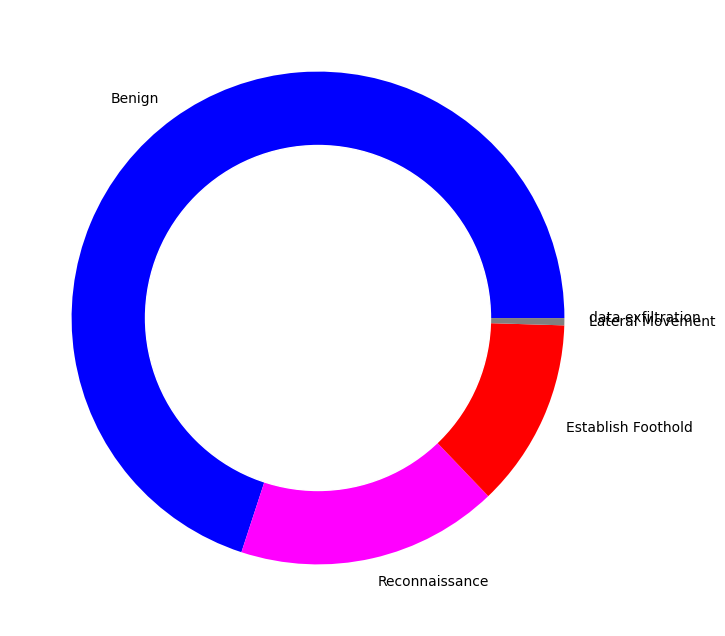

In [31]:
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(data_train["Stage"].value_counts(), labels=labels, colors=['blue', 'magenta', 'red', 'grey', "pink"])

p = plt.gcf()
p.gca().add_artist(circle)

In [35]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

def downsample_mean_with_label(df, group_size, value_column, label_column):
    """
    Reduz o tamanho do DataFrame agrupando em blocos, tirando a média dos valores numéricos
    e mantendo o label mais frequente em cada grupo.
    
    :param df: DataFrame original
    :param group_size: Número de linhas por grupo para fazer a média
    :param value_column: Nome da coluna com valores numéricos
    :param label_column: Nome da coluna de rótulos categóricos
    :return: DataFrame reduzido
    """

    # Criar uma coluna de agrupamento
    df['group'] = df.index // group_size

    # Calcular a média dos valores numéricos dentro de cada grupo
    df_reduced = df.groupby('group')[value_column].mean().reset_index(drop=True)

    # Para os labels, pegamos o mais frequente dentro do grupo
    df_labels = df.groupby('group')[label_column].agg(lambda x: x.mode().iloc[0]).reset_index(drop=True)

    # Combinar os valores numéricos com os labels
    df_final = pd.DataFrame({value_column: df_reduced, label_column: df_labels})

    return df_final

class load_and_resample_data(Dataset):
    def __init__(self, filename, label_column, seq_len, n_samples=10000):
        assert n_samples % seq_len == 0, "O número de linhas deve ser divisível por seq_len"

        data_train = pd.read_csv(filename)

        # apenas as colunas flowm flow packets/s e timestamp
        data_train = data_train[['Flow Packets/s', 'Flow Bytes/s', 'Timestamp', label_column]]

        # Converte 'Timestamp' para datetime com o formato específico
        data_train['Timestamp'] = pd.to_datetime(data_train['Timestamp'], errors='coerce')

        # Define 'Timestamp' como índice
        data_train.set_index('Timestamp', inplace=True)

        #sort pelo timestamp
        data_train.sort_index(inplace=True)

        # Convertendo as classes para números
        data_train[label_column] = pd.Categorical(data_train[label_column]).codes

        Y_train = data_train[label_column]
        X_train = data_train.drop([label_column], axis=1)

        # Drop de colunas não numéricas
        X_train = X_train.apply(pd.to_numeric, errors='coerce')
        X_train = X_train.select_dtypes(include=[np.number])

        # resample usando a media do X_train e o ultimo label
        X_train = X_train.resample('1S').agg('mean')
        Y_train = Y_train.resample('1S').last()

        #remove nan values
        X_train.dropna(inplace=True)
        Y_train.dropna(inplace=True)

        #y_train with nan values, replace for 0
        Y_train.fillna(0, inplace=True)

        # remove os ultimos valores para fechar n_samples
        X_train = X_train.iloc[:n_samples]
        Y_train = Y_train.iloc[:n_samples]

        # Normalização usando MinMaxScaler
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)

        # Garantir que o número de amostras seja divisível por seq_len
        self.X_train = self.X_train[:len(self.X_train) // seq_len * seq_len]
        self.X_train = self.X_train.reshape(self.X_train.shape[0] // seq_len, seq_len, self.X_train.shape[1])
        self.X_train = np.transpose(self.X_train, (0, 2, 1))
        self.X_train = np.expand_dims(self.X_train, axis=2)  # (batch, seq_len, colunas, 1)

        # (batch, seq_len) - último valor da sequência
        self.Y_train = Y_train.values
        self.Y_train = self.Y_train.reshape(self.Y_train.shape[0] // seq_len, seq_len)[:, -1]

        print(f'X_train shape is {self.X_train.shape}')
        print(f'y_train shape is {self.Y_train.shape}')

        # Imprimir quantidades de amostras por classe
        for i in range(len(np.unique(self.Y_train))):
            print(f'Class {i} has {np.sum(self.Y_train == i)} samples')
        
    def __len__(self):
        return len(self.Y_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.Y_train[idx]


seq_len = 20
train_set = load_and_resample_data("cyberdata/train.csv", "Stage", seq_len, 20000) 
x_train = train_set.X_train
y_train = train_set.Y_train
# (batch_size, chanels, 1, seq_len)

X_train shape is (1000, 2, 1, 20)
y_train shape is (1000,)
Class 0 has 268 samples
Class 1 has 684 samples
Class 2 has 16 samples
Class 3 has 3 samples
Class 4 has 29 samples


In [36]:
def plot_samples(data, classnames, labels = None, offset = 0):
    fig, axs = plt.subplots(2, 5, figsize=(20, 5))
    fig.suptitle(f'Network Traffic', fontsize=15)  # Exemplo de título, ajuste conforme necessário

    colors = ['b', 'r']  # Azul para a primeira variável, vermelho para a segunda

    for i in range(2):
        for j in range(5):
            axs[i, j].plot(data[i*2 + j + offset, 1, 0, :], color=colors[1], label=classnames[1])
            axs[i, j].plot(data[i*2 + j + offset, 0, 0, :], color=colors[0], label=classnames[0])

    #change the background color based on the label
    if labels is not None:
        for i in range(2):
            for j in range(5):
                if labels[i*5 + j + offset] == 1:
                    axs[i, j].set_facecolor('lightgreen')
                else:
                    axs[i, j].set_facecolor('lightcoral')

    # Criar uma única legenda para toda a figura
    handles = [plt.Line2D([0], [0], color=colors[k], lw=2) for k in range(len(classnames))]
    fig.legend(handles, classnames, loc='upper right', fontsize=12)

    plt.show()



In [ ]:
def plot_n_samples(data, classnames, num_samples, labels=None, offset = 0):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['b', 'r']  # Azul para a primeira variável, vermelho para a segunda
    count = 0

    for i in range(num_samples):
        seq_len = data.shape[-1]
        x = np.arange(seq_len) + count  # Ajusta a posição no eixo x para evitar sobreposição
        ax.plot(x, data[i + offset, 0, 0, :], color=colors[0], label=classnames[0] if i == 0 else "")
        ax.plot(x, data[i + offset, 1, 0, :], color=colors[1], label=classnames[1] if i == 0 else "")
        count += seq_len  # Move o próximo conjunto de dados para a direita

    if labels is not None:
        for i in range(num_samples):
            if labels[i + offset] == 1:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightgreen', alpha=0.5)
            else:
                ax.axvspan(i * seq_len, (i + 1) * seq_len, color='lightcoral', alpha=0.5)

    plt.title("Trafego de rede")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.show()

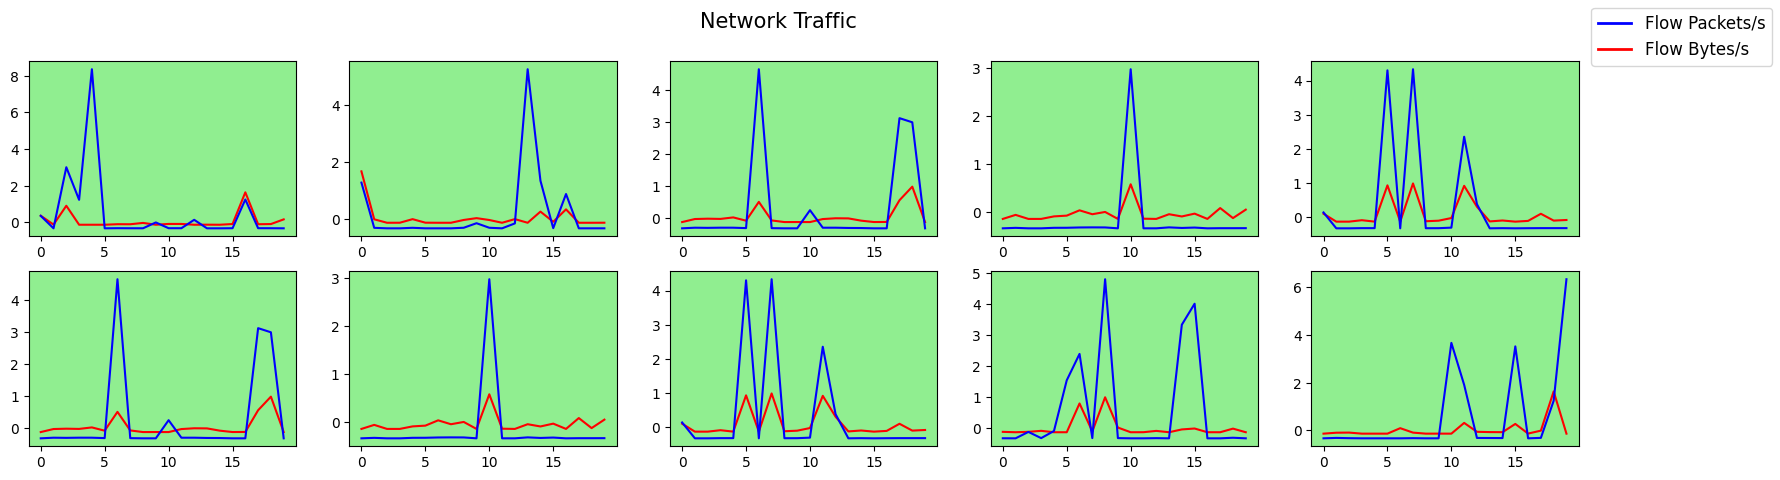

In [38]:
plot_samples(x_train, ['Flow Packets/s', 'Flow Bytes/s'], y_train, 950)


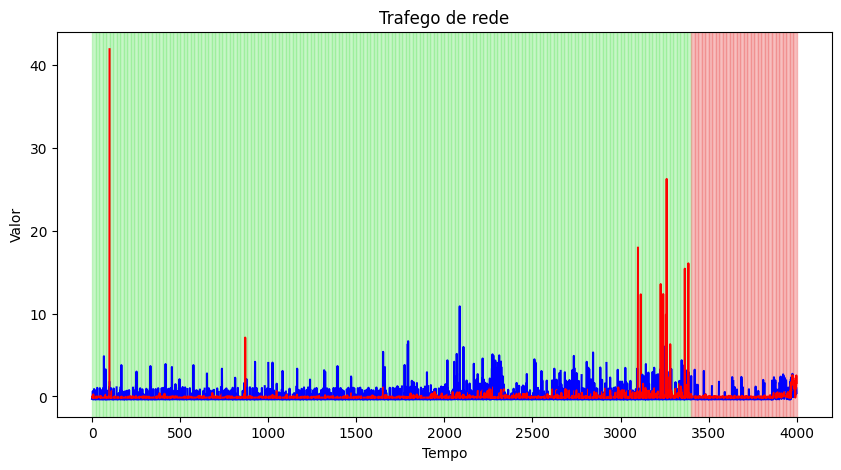

In [46]:
plot_n_samples(x_train, ['Flow Packets/s', 'Flow Bytes/s'], 200, y_train, 100)

## Gerando dados sinteticos

In [8]:
import matplotlib.pyplot as plt
from TransCGAN_model import *

In [12]:
patch_size = 1
seq_len = 20
num_channels = train_set.X_train.shape[1]
num_classes = len(np.unique(train_set.Y_train))
CGAN_model_path = 'logs\mitbithCGAN_2025_03_05_18_03_08\Model\checkpoint'

In [10]:
gen_net = Generator(seq_len=seq_len, channels=num_channels, num_classes=num_classes, latent_dim=100, data_embed_dim=10, 
                    label_embed_dim=10 ,depth=3, num_heads=5, 
                    forward_drop_rate=0.5, attn_drop_rate=0.5)

In [13]:
CGAN_ckp = torch.load(CGAN_model_path)
gen_net.load_state_dict(CGAN_ckp['gen_state_dict'])

<All keys matched successfully>

In [86]:
synthetic_data = [] 
synthetic_labels = []
new_samples = 20

fake_noise = torch.FloatTensor(np.random.normal(0, 2, (new_samples, 100)))
fake_label = torch.randint(0, 2, (new_samples,))
fake_sigs = gen_net(fake_noise, fake_label).to('cpu').detach().numpy()

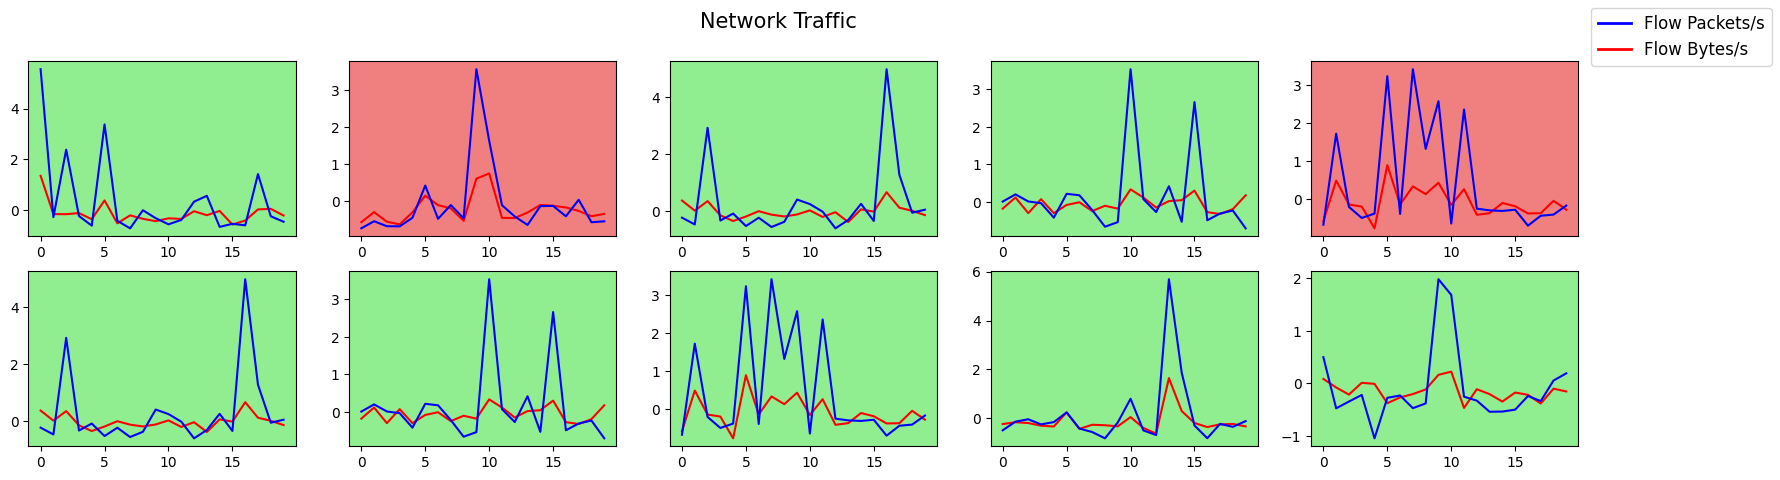

In [87]:
plot_samples(np.array(fake_sigs), ['Flow Packets/s', 'Flow Bytes/s'], fake_label, 0)

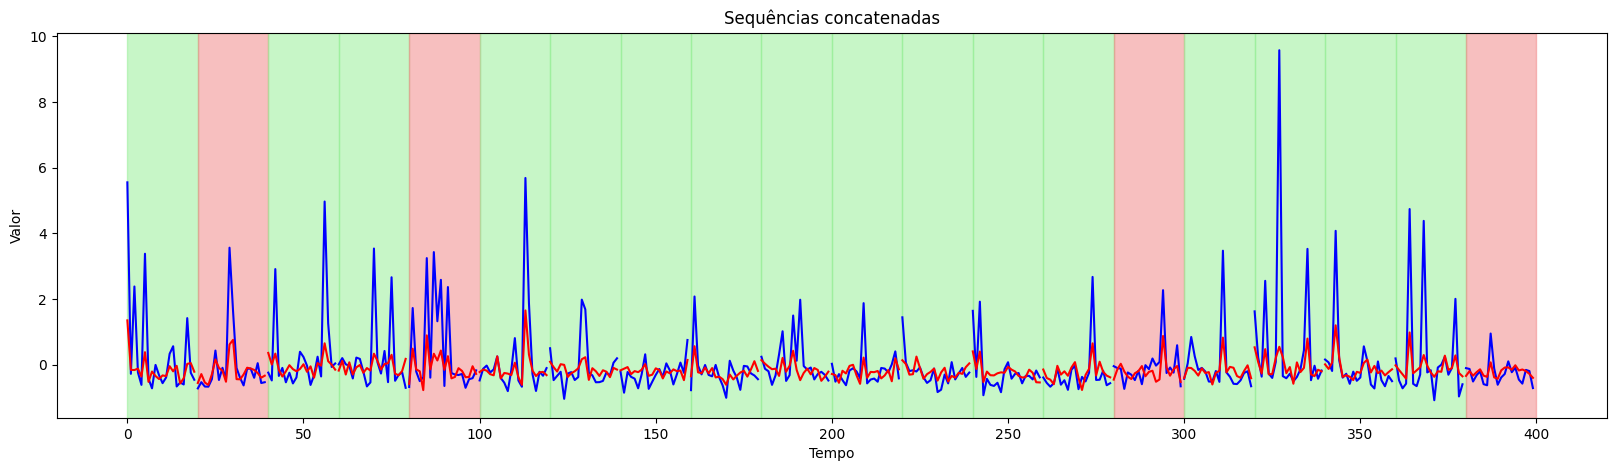

In [98]:
plot_n_samples(np.array(fake_sigs), ['Flow Packets/s', 'Flow Bytes/s'], 20, fake_label)

In [ ]:
class_dict = {'Non-Ectopic Beats':0, 'Superventrical Ectopic':1, 'Ventricular Beats':2, 'Unknown':3, 'Fusion Beats':4}
def plot_synthetic_heartbeat(classname):
    synthetic_data = [] 
    synthetic_labels = []
    for i in range(10):
        fake_noise = torch.FloatTensor(np.random.normal(0, 1, (1, 100)))
        fake_label = torch.tensor([class_dict[classname]])
        fake_sigs = gen_net(fake_noise, fake_label).to('cpu').detach().numpy()

        synthetic_data.append(fake_sigs)
        synthetic_labels.append(fake_label)

    fig, axs = plt.subplots(2, 5, figsize=(20,5))
    fig.suptitle(f'Synthetic HeartBeat {classname}', fontsize=15)
    for i in range(2):
        for j in range(5):
            axs[i, j].plot(synthetic_data[i*5+j][0][0][0][:])
            axs[i, j].title.set_text(synthetic_labels[i*5+j])

In [ ]:
class_dict = {'Non-Ectopic Beats':0, 'Superventrical Ectopic':1, 'Ventricular Beats':2, 'Unknown':3, 'Fusion Beats':4}
def plot_synthetic_heartbeat(classname):
    synthetic_data = [] 
    synthetic_labels = []
    for i in range(4):
        fake_noise = torch.FloatTensor(np.random.normal(0, 1, (1, 100)))
        fake_label = torch.tensor([class_dict[classname]])
        fake_sigs = gen_net(fake_noise, fake_label).to('cpu').detach().numpy()

        synthetic_data.append(fake_sigs)
        synthetic_labels.append(fake_label)

    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    fig.suptitle(f'Synthetic {classname}', fontsize=15)
    for i in range(4):
        axs[i].plot(synthetic_data[i][0][0][0][:])
    plt.savefig(f'./syn_{classname}.pdf', format="pdf")

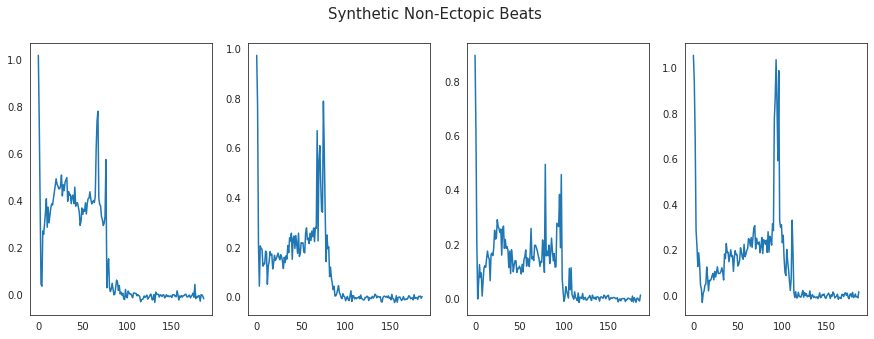

In [ ]:
plot_synthetic_heartbeat('Non-Ectopic Beats')

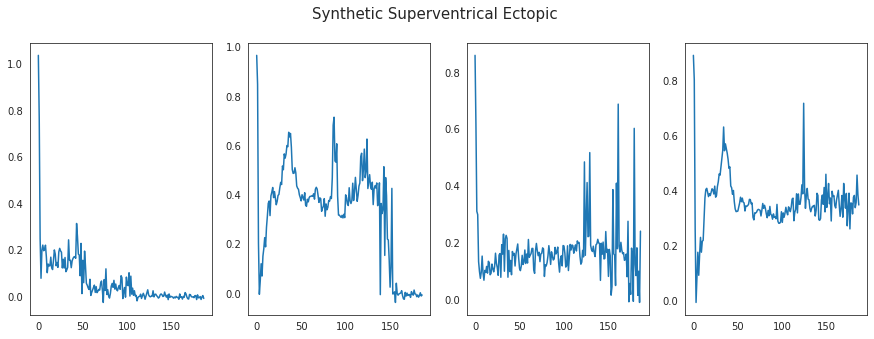

In [ ]:
plot_synthetic_heartbeat('Superventrical Ectopic')

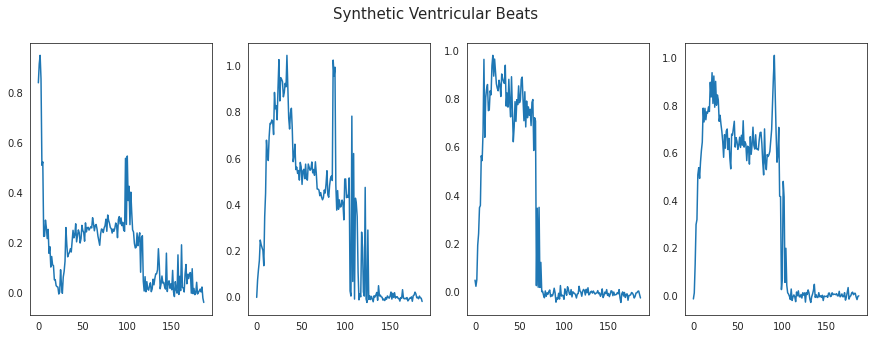

In [ ]:
plot_synthetic_heartbeat('Ventricular Beats')

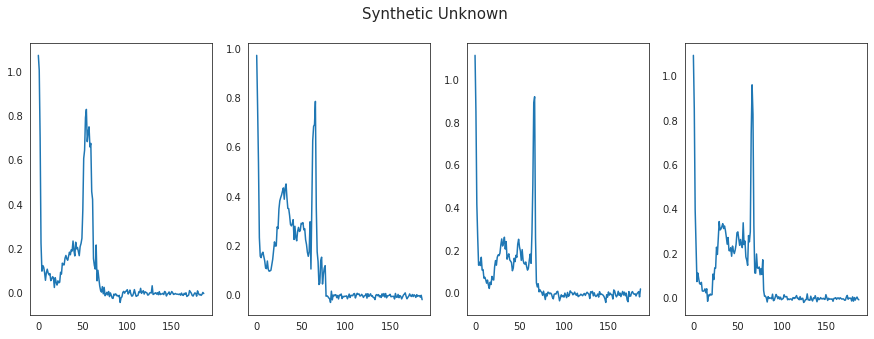

In [ ]:
plot_synthetic_heartbeat('Unknown')

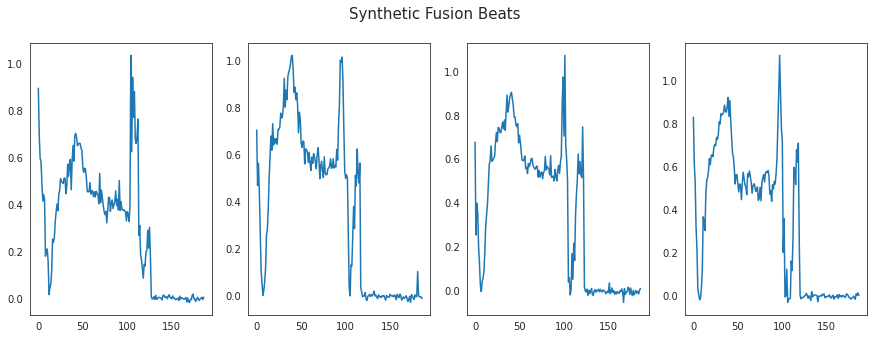

In [ ]:
plot_synthetic_heartbeat('Fusion Beats')

In [ ]:
from synDataLoader import *
from torch.utils import data

In [ ]:
syn_ecg = syn_mitbih(n_samples=1000, reshape=True)

data shape is (5000, 187)
labels shape is (5000,)
The dataset including 1000 class 0, 1000 class 1, 1000 class 2, 1000 class 3, 1000 class 4


In [ ]:
def plot_hist_syn(data,start,size,bins, filename="test_syn"):
    sigs=data[:, start:size]
#     end = start+size
#     sigs=sigs[:,start:end]
    sigs_flatten=sigs.flatten()

    final1=np.arange(start,size)
    for i in range (sigs.shape[0]-1):
        tempo1=np.arange(start,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(sigs_flatten))
    plt.hist2d(final1,sigs_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.savefig(f'{filename}.pdf')
    plt.show()

In [ ]:
def plot_hist(data,start,size,bins, filename="test_real"):
    sigs=data.iloc[:, start:size].to_numpy()
#     end = start+size
#     sigs=sigs[:,start:end]
    sigs_flatten=sigs.flatten()

    final1=np.arange(start,size)
    for i in range (sigs.shape[0]-1):
        tempo1=np.arange(start,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(sigs_flatten))
    plt.hist2d(final1,sigs_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.savefig(f'{filename}.pdf')
    plt.show()

65000
65000


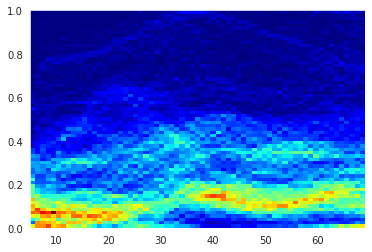

In [ ]:
plot_hist(data_0[:1000],5,70,65, "data_0_real")

65000
65000


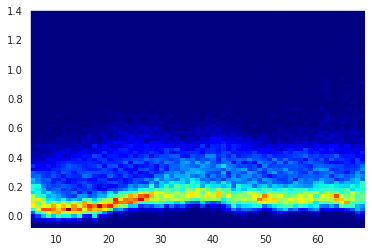

In [ ]:
plot_hist_syn(syn_ecg.syn_0,5,70,65, "data_0_syn")

45000
45000


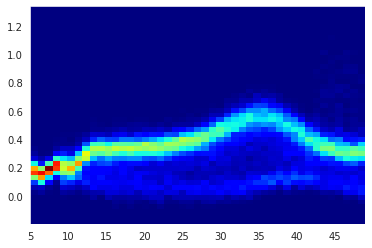

In [ ]:
plot_hist_syn(syn_ecg.syn_1,5,50,45, "data_1_syn")

45000
45000


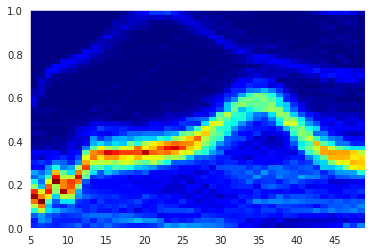

In [ ]:
plot_hist(data_1[:1000],5,50,45, "data_1_real")

45000
45000


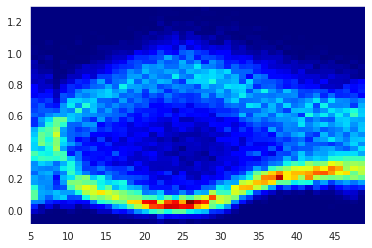

In [ ]:
plot_hist_syn(syn_ecg.syn_2,5,50,45, "data_2_syn")

45000
45000


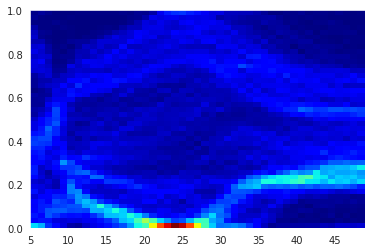

In [ ]:
plot_hist(data_2[:1000],5,50,45, "data_2_real")

45000
45000


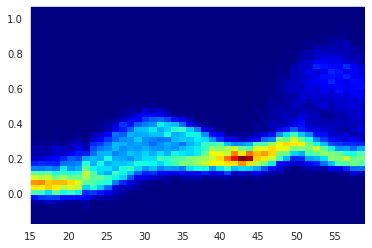

In [ ]:
plot_hist_syn(syn_ecg.syn_3,15,60,45, "data_3_syn")

28845
28845


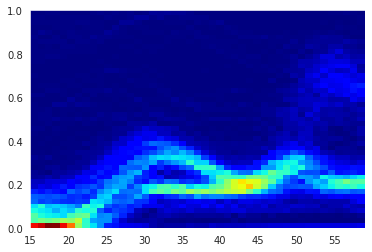

In [ ]:
plot_hist(data_3[:1000],15,60,45, "data_3_real")

45000
45000


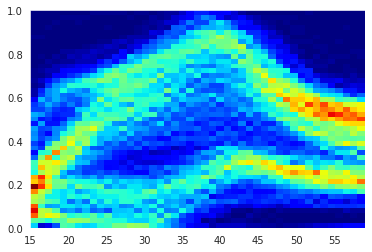

In [ ]:
plot_hist(data_4[:1000],15,60,45, "data_4_real")

45000
45000


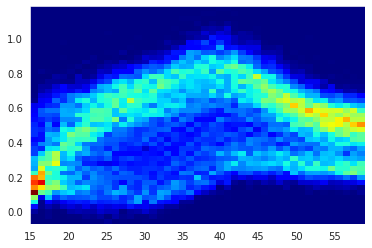

In [ ]:
plot_hist_syn(syn_ecg.syn_4,15,60,45, "data_4_syn")